<a href="https://colab.research.google.com/github/vestinabert/Image_Processing/blob/main/Image_Edge_Detection_And_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 02025.jpg to 02025 (1).jpg


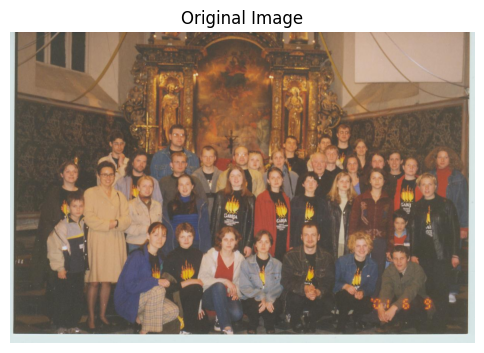

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Upload images
uploaded = files.upload()

# Load and display the first uploaded image
image_name = list(uploaded.keys())[0]
image = cv2.imdecode(np.frombuffer(uploaded[image_name], np.uint8), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Show original image
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()


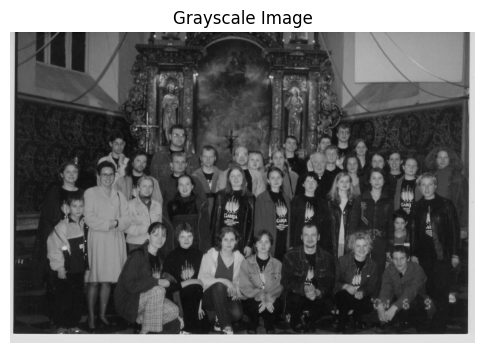

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Show grayscale image
plt.figure(figsize=(6,6))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()


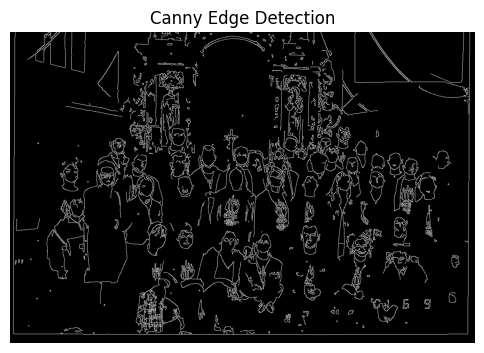

In [ ]:
# Apply Canny Edge Detection
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Show edges
plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()


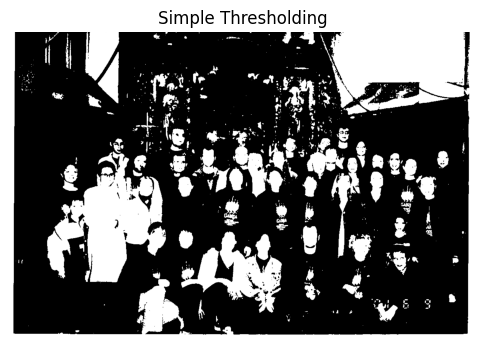

In [ ]:
ret, thresh_simple = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(thresh_simple, cmap='gray')
plt.title("Simple Thresholding")
plt.axis("off")
plt.show()


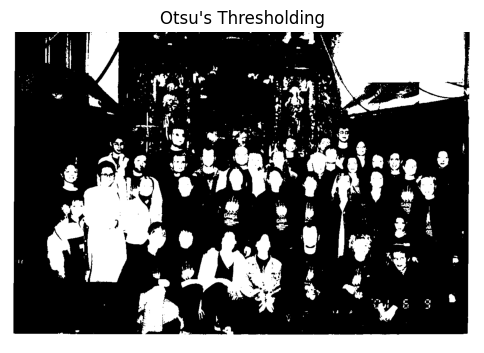

In [ ]:
ret, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(thresh_otsu, cmap='gray')
plt.title("Otsu's Thresholding")
plt.axis("off")
plt.show()


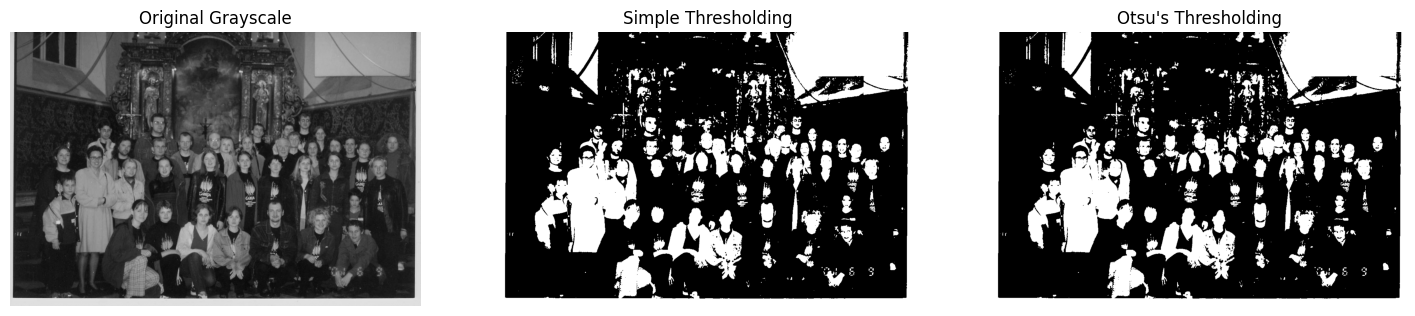

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Original Grayscale")
axes[0].axis("off")

axes[1].imshow(thresh_simple, cmap='gray')
axes[1].set_title("Simple Thresholding")
axes[1].axis("off")

axes[2].imshow(thresh_otsu, cmap='gray')
axes[2].set_title("Otsu's Thresholding")
axes[2].axis("off")

plt.show()


Saving 02025.jpg to 02025.jpg
Loaded as API: https://finegrain-finegrain-object-cutter.hf.space ✔
API Response for 02025.jpg: (['/tmp/gradio/8ba903d756e642c2d8faba5815e23a79412e3acbf3a8f0bd0cda117a243ea7e2/image.webp', '/tmp/gradio/b53a153c6b4ffb6e8921dd59d30b67dc81fa87ed0231908412b79211e1863b2c/image.webp'], {'interactive': True, 'value': '/tmp/gradio/7aaa21620fe7aa25c6f5f3e88e108043198b304e170976a4519eed7b5bbe0740/tmprw4wugt1.png', '__type__': 'update'})
File moved to segmented_02025.jpg


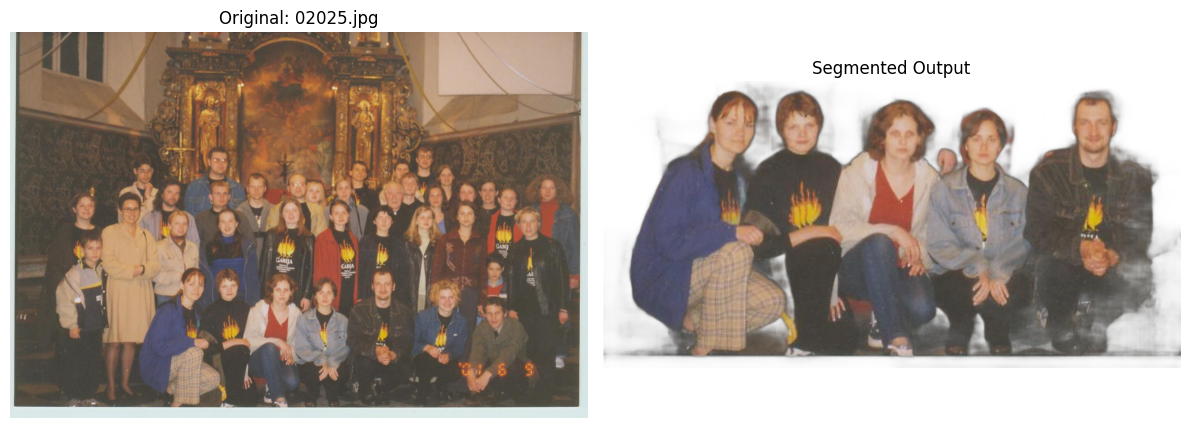

In [3]:
from gradio_client import Client, handle_file
from PIL import Image
import io
import requests
import shutil
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
uploaded = files.upload()  # Allows multiple file selection

# Load images into a dictionary
images = {}
for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename]))  # Open image using PIL
    images[filename] = image

# Convert images to grayscale
gray_images = {}
for filename, image in images.items():
    gray_image = image.convert("L")  # Convert to grayscale
    gray_images[filename] = gray_image

# Initialize Hugging Face model
client = Client("finegrain/finegrain-object-cutter")

# Process each uploaded image
for filename, image in images.items():

    processed_image_path = f"processed_{filename}"
    image.save(processed_image_path)

    try:
        result = client.predict(
            img=handle_file(processed_image_path),
            prompt="Cut out the main object",
            api_name="/process_prompt"
        )

        # Debug: Print API Response
        print(f"API Response for {filename}:", result)

        # Handle API response
        if isinstance(result, tuple) and len(result) == 2:
            file_list, output_info = result

            # Extract the segmented image file from the response
            if isinstance(output_info, dict) and "value" in output_info:
                segmented_image_path = output_info["value"]

                # Move the file from /tmp/ to our working directory
                output_filename = f"segmented_{filename}"
                shutil.move(segmented_image_path, output_filename)
                print(f"File moved to {output_filename}")

            else:
                raise ValueError(f"Unexpected dictionary format in API response: {output_info}")

        elif isinstance(result, str) and result.startswith("http"):
            # If the response is a URL, download the image
            response = requests.get(result)
            output_filename = f"segmented_{filename}"

            with open(output_filename, "wb") as f:
                f.write(response.content)

            print(f"Downloaded image saved as {output_filename}")

        else:
            raise ValueError(f"Unexpected response format from API: {result}")

        # 6️⃣ Display the AI-segmented output and original image
        original_image = Image.open(processed_image_path)
        segmented_output = Image.open(output_filename)

        # Create a side-by-side comparison of the original and segmented images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display original image
        axes[0].imshow(original_image)
        axes[0].set_title(f"Original: {filename}")
        axes[0].axis("off")

        # Display segmented output
        axes[1].imshow(segmented_output)
        axes[1].set_title("Segmented Output")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error occurred while processing {filename}: {e}")